# Original Version in R

```R
## load libraries ####
library(data.table) # fast data loading and manipulation
library(ggplot2)  # visualization

## import data ####
dat <- fread('workshop/exercise-1/exercise-1-APC-data.csv')

## first look & summarize data ####
scales::comma(nrow(dat)) # 1,387,869 rows of APC data
summary(dat) # check range of dates, distribution of ons and offs

dat[, .N, line_id] # how many routes included?
dat[, .N, .(line_id, line_direction)] # how many route-direction observations? 
dat[, .(trips = uniqueN(trip_id)), line_id] # how many unique trips per route?
dat[, uniqueN(stop_id)] #how many stops included? 
dat[, unique(TOD)] # what does the TOD variable contain?

dat[1:10, depart] # view a sample of the data - depart
 
## What are the dimensions of the data? ####


## What is the average weekday ridership by route? ####
# sum ons by date by route, for only weekday
rides_by_day <- dat[service_abbr == 'WK', .(daily_rides = sum(total_ons)), keyby = .(calendar_date, line_id)] # keyby gives an additional benefit of fast sorting by the aggregator columns... try using just 'by'

# then take the average across all the weekdays in the dataset
weekday_avg <- rides_by_day[, .(weekday_avg = mean(daily_rides)), line_id]
weekday_avg # print result
weekday_avg[, .(line_id, WK_avg = scales::comma(weekday_avg))] # round and format nicely



## what is the busiest stop in the dataset? ####
# decide: what does busiest mean? 
# assume: most total boardings

# create list of total boardings across all days by route, stop
stop_boards <- dat[, .(total_boardings = sum(total_ons)), .(stop_id, line_id)]

# sort by total boardings in dataset
stop_boards[order(-total_boardings)] # sorting by "-" means sort descending


## how does ridership correspond with peak times of day? ####
# take weekday average, by TOD, by line_id - similar to first aggregate but additional factor
rides_by_day_tod <- dat[service_abbr == 'WK', .(daily_rides = sum(total_ons)), keyby = .(calendar_date, line_id, TOD)] 

# summarize by taking median instead of mean to get better sense of regular activity
weekday_avg_tod <- rides_by_day_tod[, .(weekday_avg = mean(daily_rides)), .(line_id, TOD)]

# make a new variable to look at peak times only for ease of comparison
weekday_avg_tod[, peak := ifelse(TOD %in% c('AM Peak', 'PM Peak'), TRUE, FALSE)]
weekday_avg_tod[, sum(weekday_avg), peak]

## graph of ridership time series ####
# first aggregate to monthly average weekday boardings, using first aggregate
toplot <- rides_by_day[, .(avg_wkday = mean(daily_rides)), keyby = .(month(calendar_date), line_id)]

ggplot(toplot, aes(x = factor(month), y = avg_wkday, col = factor(line_id))) + 
  geom_path(aes(group = line_id)) +
  geom_point(alpha = 0.6) 

```

Credit by [TRB Standing Committee on Transit Data](https://github.com/trb-transformative-transit-data/tttd)

# Code in Python

In [118]:
## load libraries ##
import os
import numpy as np
import pandas as pd # data manipulation

from scipy.stats import gaussian_kde # kernel density plot
from numpy import linspace

import matplotlib.pyplot as plt # visualization

In [13]:
## pandas configurations ##
pd.options.display.float_format = "{:,.2f}".format

In [7]:
os.getcwd()

'C:\\Users\\shin\\OneDrive - UOS\\10. Computer (UoS)\\05. Seminar (ITS LAB)\\2023-01\\Hands-on'

In [8]:
## import data ##
dat = pd.read_csv("./workshop/exercise-1/exercise-1-APC-data.csv")

## 1. Examine data columns

In [10]:
dat.shape

(1387869, 11)

In [12]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387869 entries, 0 to 1387868
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   calendar_date   1387869 non-null  object 
 1   service_abbr    1387869 non-null  object 
 2   line_id         1387869 non-null  int64  
 3   line_direction  1387862 non-null  object 
 4   trip_id         1385810 non-null  float64
 5   stop_id         1387862 non-null  object 
 6   TOD             1387869 non-null  object 
 7   depart          1387862 non-null  object 
 8   sched           1387862 non-null  object 
 9   total_ons       1387869 non-null  int64  
 10  total_offs      1387869 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 116.5+ MB


In [14]:
dat.describe()

,line_id,trip_id,total_ons,total_offs
count,"1,387,869.00","1,385,810.00","1,387,869.00","1,387,869.00"
mean,40.63,"18,740,364.76",1.06,1.05
std,20.41,"577,434.73",1.55,1.51
min,22.00,"17,784,415.00",0.00,0.00
25%,22.00,"18,272,681.00",0.00,0.00
50%,22.00,"18,791,896.00",1.00,1.00
75%,63.00,"19,090,773.00",1.00,1.00
max,63.00,"20,104,413.00",91.00,164.00


In [17]:
dat.groupby("line_id").size()

line_id
22    757115
63    630754
dtype: int64

In [20]:
dat.groupby(["line_id", "line_direction"], dropna=False).size()

line_id  line_direction
22       N                 367946
         S                 389169
63       E                 311507
         W                 319240
         NaN                    7
dtype: int64

From `pandas 1.1` you have better control over this behavior, `NA` values are now allowed in the grouper using `dropna=False`.
[\[source\]](https://stackoverflow.com/questions/18429491/pandas-groupby-columns-with-nan-missing-values)

In [23]:
dat["stop_id"].nunique()

501

In [25]:
dat["TOD"].unique()

array(['AM Peak', 'Early', 'Midday', 'PM Peak', 'Night', 'Owl'],
      dtype=object)

## 2. Code or pseudo-code the answer to the following queries

1. What is the average weekday ridership by route?
1. What is the busiest stop in the dataset?
1. How does ridership correspond with "peak" times of day?

### 2-1. the average weekday ridership by route

In [37]:
rides_by_day = dat.loc[dat.service_abbr == "WK"].groupby(["calendar_date", "line_id"], dropna=False).agg(\
                                                daily_rides = pd.NamedAgg(column="total_ons", aggfunc="sum"))

In [38]:
rides_by_day

daily_rides
calendar_date line_id             
2021-01-04    22              2151
              63              1850
2021-01-05    22              1818
              63              1645
2021-01-06    22              1971
...                            ...
2021-12-29    63              1558
2021-12-30    22              2092
              63              1582
2021-12-31    22              1822
              63              1272

[510 rows x 1 columns]

In [39]:
rides_by_day.groupby("line_id").agg(\
                                weekday_avg = pd.NamedAgg(column="daily_rides", aggfunc="mean"))

,weekday_avg
line_id,
22,"2,481.29"
63,"2,044.60"


### 2-2. the busiest stop in the dataset

In [45]:
stop_boards = dat.groupby(["stop_id", "line_id"], dropna=False).agg(\
                                    total_boardings = pd.NamedAgg(column="total_ons", aggfunc="sum"))

In [48]:
stop_boards.sort_values("total_boardings", ascending=False)

,,total_boardings
stop_id,line_id,
11837,63,69743
51114,63,65089
56825,22,59844
53788,22,43734
11180,22,27813
...,...,...
11463,22,1
53878,22,0
19440,22,0


### 2-3. correspondence of ridership with "PK" TOD

In [51]:
rides_by_day_tod = dat.loc[dat.service_abbr == "WK"].groupby(["calendar_date", "line_id", "TOD"]).agg(\
                                                                    daily_rides = pd.NamedAgg(column="total_ons", aggfunc="sum"))

In [183]:
weekday_avg_tod = rides_by_day_tod.groupby(["line_id", "TOD"]).agg(\
                                            weekday_avg = pd.NamedAgg(column="daily_rides", aggfunc="mean"))

(22, 'AM Peak')


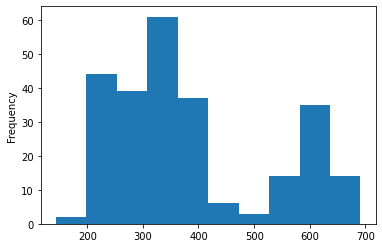

(22, 'Early')


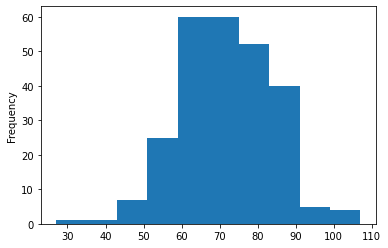

(22, 'Midday')


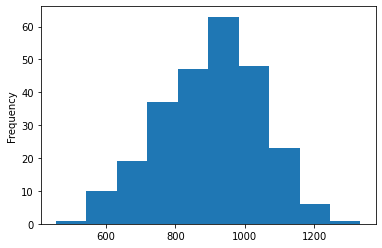

(22, 'Night')


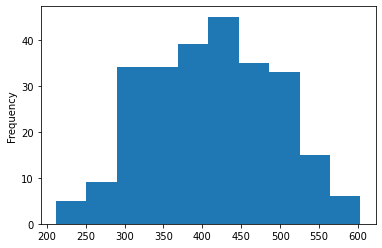

(22, 'Owl')


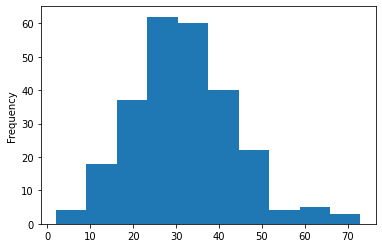

(22, 'PM Peak')


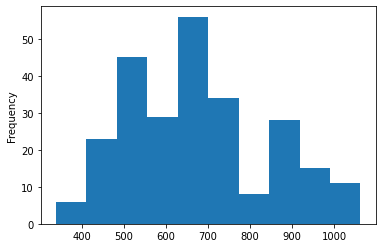

(63, 'AM Peak')


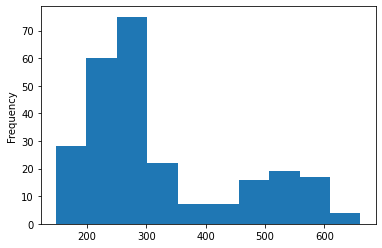

(63, 'Early')


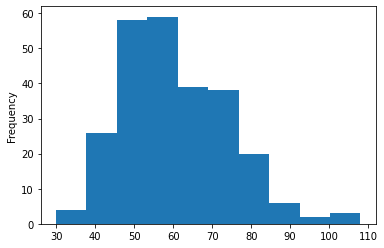

(63, 'Midday')


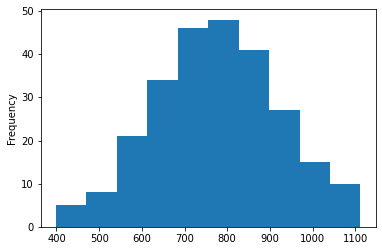

(63, 'Night')


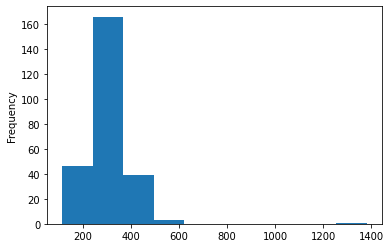

(63, 'Owl')


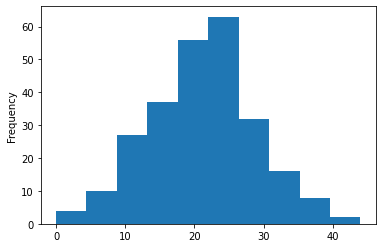

(63, 'PM Peak')


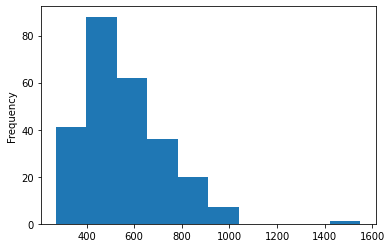

In [232]:
for name, group in rides_by_day_tod.groupby(["line_id", "TOD"]):
    print(name)
    group.daily_rides.plot.hist()
    plt.show()

(22, 'AM Peak')


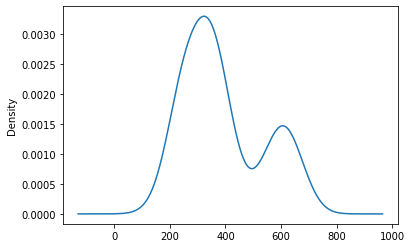

(22, 'Early')


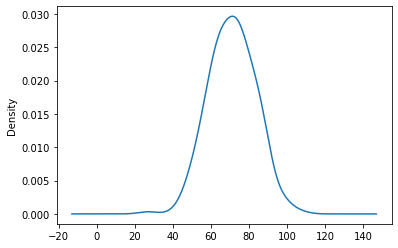

(22, 'Midday')


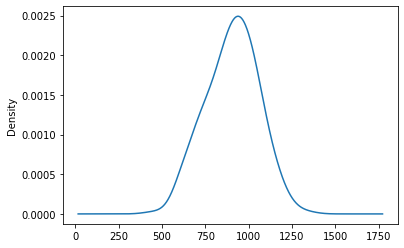

(22, 'Night')


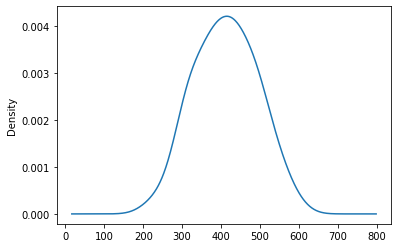

(22, 'Owl')


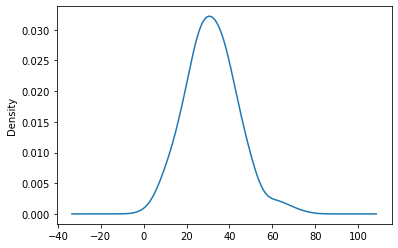

(22, 'PM Peak')


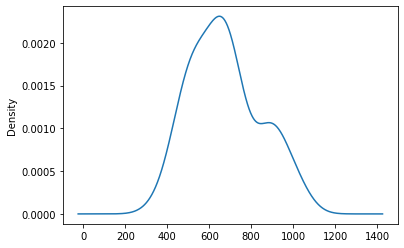

(63, 'AM Peak')


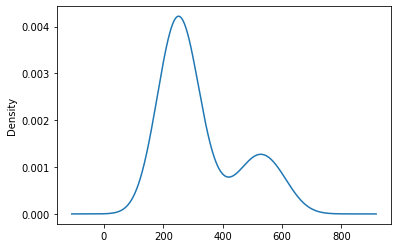

(63, 'Early')


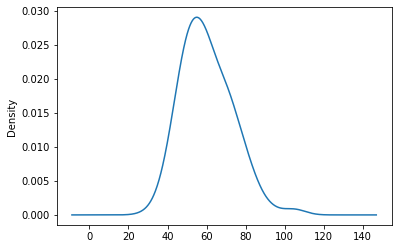

(63, 'Midday')


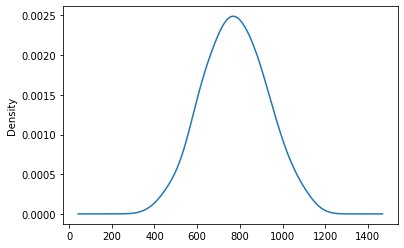

(63, 'Night')


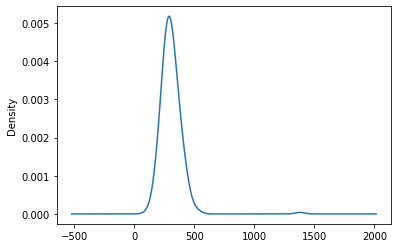

(63, 'Owl')


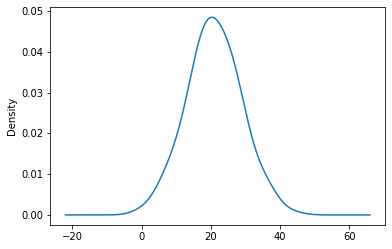

(63, 'PM Peak')


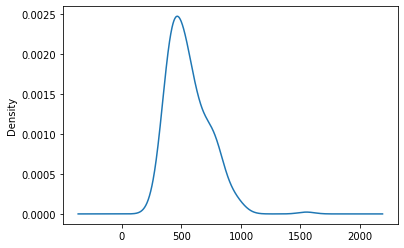

In [231]:
for name, group in rides_by_day_tod.groupby(["line_id", "TOD"]):
    print(name)
    group.daily_rides.plot.kde(bw_method=.4)
    plt.show()

Pop Quiz

1. 그룹별로 각각 커널밀도함수 분포 확인하기 **(Solved)**
1. 조건에 따라서 True, False 부여하는 구문 in Python & Pandas **(Solved)**

In [227]:
## Quiz 2 ##
weekday_avg_tod.index.isin(["AM Peak", "PM Peak"], level=1)

array([ True, False, False, False, False,  True,  True, False, False,
       False, False,  True])

In [188]:
weekday_avg_tod["peak"] = np.where(weekday_avg_tod.index.isin(["AM Peak", "PM Peak"], level=1), True, False)

In [189]:
weekday_avg_tod

weekday_avg   peak
line_id TOD                        
22      AM Peak       388.06   True
        Early          71.24  False
        Midday        904.25  False
        Night         411.96  False
        Owl            31.69  False
        PM Peak       674.09   True
63      AM Peak       322.69   True
        Early          60.28  False
        Midday        775.33  False
        Night         306.44  False
        Owl            20.97  False
        PM Peak       558.89   True

In [190]:
weekday_avg_tod.groupby("peak").agg(\
                                total_counts=pd.NamedAgg(column="weekday_avg", aggfunc="sum"))

,total_counts
peak,
False,"2,582.16"
True,"1,943.73"


## 3. Sketch a graph of a ridership timeseries

In [191]:
rides_by_day.groupby(["calendar_date", "line_id"]).agg(\
                                                   avg_wkday=pd.NamedAgg(column="daily_rides", aggfunc="mean"))

avg_wkday
calendar_date line_id           
2021-01-04    22        2,151.00
              63        1,850.00
2021-01-05    22        1,818.00
              63        1,645.00
2021-01-06    22        1,971.00
...                          ...
2021-12-29    63        1,558.00
2021-12-30    22        2,092.00
              63        1,582.00
2021-12-31    22        1,822.00
              63        1,272.00

[510 rows x 1 columns]

In [211]:
new_rides_by_day = rides_by_day.reset_index()

In [212]:
new_rides_by_day.calendar_date = pd.to_datetime(new_rides_by_day.calendar_date)

In [216]:
new_rides_by_day["month"] = new_rides_by_day.calendar_date.apply(lambda x: x.month)

In [217]:
new_rides_by_day

,calendar_date,line_id,daily_rides,month
0,2021-01-04,22,2151,1
1,2021-01-04,63,1850,1
2,2021-01-05,22,1818,1
3,2021-01-05,63,1645,1
4,2021-01-06,22,1971,1
...,...,...,...,...
505,2021-12-29,63,1558,12
506,2021-12-30,22,2092,12
507,2021-12-30,63,1582,12
508,2021-12-31,22,1822,12


In [233]:
toplot = new_rides_by_day.groupby(["month", "line_id"]).agg(\
                        avg_wkday=pd.NamedAgg(column="daily_rides", aggfunc="mean"))

In [234]:
toplot

avg_wkday
month line_id           
1     22        1,904.80
      63        1,516.10
2     22        1,842.00
      63        1,462.35
3     22        2,005.70
      63        1,745.70
4     22        2,168.95
      63        1,918.41
5     22        2,334.65
      63        1,864.70
6     22        2,512.82
      63        1,924.18
7     22        2,565.50
      63        1,992.27
8     22        2,621.82
      63        2,036.77
9     22        3,100.05
      63        2,696.81
10    22        3,102.76
      63        2,676.81
11    22        3,014.85
      63        2,483.85
12    22        2,604.18
      63        2,211.86

In [251]:
# line 63
toplot.loc[(slice(None), 63), :]

,,avg_wkday
month,line_id,
1,63,"1,516.10"
2,63,"1,462.35"
3,63,"1,745.70"
4,63,"1,918.41"
5,63,"1,864.70"
6,63,"1,924.18"
7,63,"1,992.27"
8,63,"2,036.77"
9,63,"2,696.81"


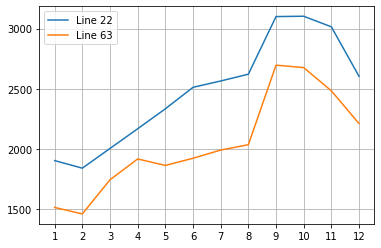

In [258]:
plt.plot(toplot.loc[(slice(None), 22), :].droplevel(1), label="Line 22")
plt.plot(toplot.loc[(slice(None), 63), :].droplevel(1), label="Line 63")
plt.xticks(range(1, 13))
plt.yticks(range(1500, 3100, 500))
plt.grid(which="major", axis='both')
plt.legend()
plt.show()